# Analysis of a two-phase (phase separated) simulation

In this previous example, we analyzed a simulation conducted above the critical temperature.
In this tutorial, we now consider an LJ simulation with potentially two phases at $T^*=1.2$.

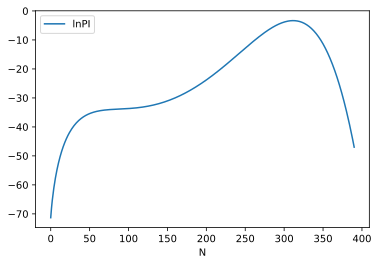

In [1]:
import numpy as np
import pandas as pd

dfsrsw = pd.read_csv("../test/data/stat120.csv")
beta = 1./1.2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
ax = dfsrsw.plot('N', 'lnPI')

Note that this macrostate distribution may contain a second maximum depending on the value of the chemical potential.
But at the chemical potential shown above, the low density phase is unstable and there is no minimum.

In [5]:
# check for minimum within num_smooth macrostates
def get_min(df, dfcol, num_smooth=10):
    df['min'] = dfcol[(dfcol.shift(1) > dfcol) & (dfcol.shift(-1) > dfcol)]
    for shift in range(2, num_smooth+1):
        df['min'] = dfcol[df['min'].notna() & (dfcol.shift(shift) > dfcol) & (dfcol.shift(-shift) > dfcol)]
    return df[df['min'].notna()]
assert(len(get_min(dfsrsw, dfsrsw.lnPI))==0)

However, a minima appears after reweighting to a lower chemical potential. 

Text(0, 0.5, '$\\ln\\Pi$')

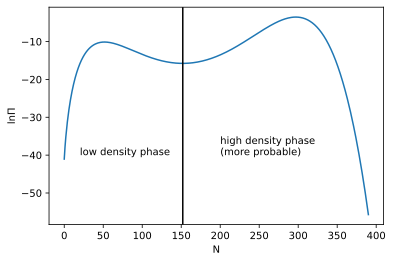

In [3]:
def rw(df, delta_conjugate, lnp_col='lnPI', n_col='N'):
    df[lnp_col+'rw'] = df[lnp_col] + df[n_col]*delta_conjugate - df[lnp_col].min()  # avoid negative log
    df[lnp_col+'rw'] -= np.log(sum(np.exp(df[lnp_col+'rw'])))   # renormalize
    return df
dfsrsw = rw(dfsrsw, delta_conjugate=-0.1)
plt.plot(dfsrsw['lnPIrw'])
minima=get_min(dfsrsw, dfsrsw.lnPIrw)
assert(len(minima) == 1 and minima['N'].values[0] == 152)
plt.gca().axvline(minima['N'].values[0], color='black')
plt.text(20, -40, 'low density phase')
plt.text(200, -40, 'high density phase\n(more probable)')
plt.xlabel('N')
plt.ylabel(r'$\ln\Pi$')

Find the chemical potential at phase equilibrium subject to the constraint that the probability of observing the two phases are equal.

Text(0, 0.5, '$\\ln\\Pi$')

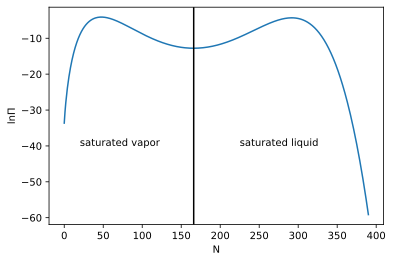

In [4]:
def equilibrium_objective(delta_beta_mu, df, num_smooth):
    df = rw(df, delta_beta_mu)
    mins=get_min(df, df['lnPIrw'])
    if len(mins) == 0:
        return (df['lnPIrw'][0] - df['lnPIrw'].values[-1])**2
    elif len(mins) == 1:
        mn=mins['N'].values[0]
        p_lo = np.exp(df["lnPIrw"][:mn]).sum()
        p_hi = np.exp(df["lnPIrw"][mn+1:]).sum()
        return abs(p_lo-p_hi)
    else:
        assert(False) # more than one minima
    
def find_equilibrium(df, delta_beta_mu_guess=-1, num_smooth=10):
    from scipy.optimize import minimize
    res = minimize(lambda delta_beta_mu: equilibrium_objective(delta_beta_mu[0], df, num_smooth), delta_beta_mu_guess, tol=1e-8)
    delta_beta_mu_equilibrium = res["x"][-1]
    df = rw(df, delta_beta_mu_equilibrium)
    return df, delta_beta_mu_equilibrium

df,delta_beta_mu_equilibrium = find_equilibrium(dfsrsw)
mins=get_min(df, df.lnPIrw)
mn=mins['N'].values[0]

plt.plot(df['lnPIrw'])
plt.gca().axvline(mn, color='black')
plt.text(20, -40, 'saturated vapor')
plt.text(225, -40, 'saturated liquid')
plt.xlabel('N')
plt.ylabel(r'$\ln\Pi$')

Compare chemical potential and equilibrium properties with published results.

https://www.nist.gov/mml/csd/chemical-informatics-research-group/sat-tmmc-liquid-vapor-coexistence-properties-long-range

In [5]:
assert(len(mins) == 1 and mins['N'].values[0] == 166)
assert(abs(-0.128071 - delta_beta_mu_equilibrium) < 0.01)

volume = 8**3
betaPV = -df["lnPIrw"][0] - 0.5
pressure=betaPV/beta/volume
print('pressure:', pressure)
assert(abs(0.07767827874744734 - pressure) < 1e-8)

vapor_density = (np.exp(df["lnPIrw"][:mn]) * df["N"][:mn]).sum()/0.5/volume # phase 0 is vapor
print('vapor_density:', vapor_density)
assert(abs(0.10035084321906751 - vapor_density) < 1e-8)

liquid_density = (np.exp(df["lnPIrw"][mn+1:]) * df["N"][mn+1:]).sum()/0.5/volume # phase 1 is liquid
print('liquid_density:', liquid_density)
assert(abs(0.5631860451773694 - liquid_density) < 1e-8)

pressure: 0.07767827874744734
vapor_density: 0.10035084321906751
liquid_density: 0.5631860451773694


Did this tutorial work as expected? Did you find any inconsistencies or have any comments? Please [contact](../../../CONTACT.rst) us. Any feedback is appreciated!